In [1]:
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, mean_squared_error
from lightgbm import early_stopping
from lightgbm import LGBMRegressor
from sklearn.model_selection import learning_curve

# Data Preprocess

In [2]:
# Load the datasets
train_data = pd.read_csv('../data/curated/train_data_2000_2024.csv')
test_data = pd.read_csv('../data/curated/test_data_2025_2027.csv')

# Sort by postcode and year
train_data = train_data.sort_values(by=['postcode', 'Year'])

# Split the train_data into two parts: 2000-2020 (train set) and 2021-2024 (validation set)
train_subset = train_data[train_data['Year'] <= 2020]
val_subset = train_data[train_data['Year'] > 2020]

# Fill NaN values introduced by pct_change
train_subset.loc[:, :] = train_subset.fillna(0)
val_subset.loc[:, :] = val_subset.fillna(0)

# Select features and target
features = ['Year', 'Bed', 'Apartment', 'postcode', 'Primary', 'Secondary', 'school_total', 'tram_count', 'bus_count', 'train_count']
target = 'Median'  # Target variable is the rent price (Median)

# Separate X and y for the 2000-2020 (train) and 2021-2024 (validation)
X_train = train_subset[features]
y_train = train_subset[target]

X_val = val_subset[features]
y_val = val_subset[target]

# Training LightGBM Model

In [3]:
# Prepare LightGBM datasets for training and validation
train_data_lgb = lgb.Dataset(X_train, label=y_train)
val_data_lgb = lgb.Dataset(X_val, label=y_val, reference=train_data_lgb)

# Set LightGBM parameters with regularization
params = {
    'objective': 'regression',  # Task type: regression
    'metric': 'rmse',  # Evaluation metric: Root Mean Squared Error (RMSE)
    'boosting_type': 'gbdt',  # Type of boosting: Gradient Boosting Decision Trees
    'learning_rate': 0.05,  # Learning rate for the model
    'num_leaves': 31,  # Maximum number of leaves per tree
    'max_depth': -1,  # No limit on the maximum depth of the trees
    'lambda_l1': 0.1,  # L1 regularization (Lasso) to control model complexity
    'lambda_l2': 0.2,  # L2 regularization (Ridge) to prevent overfitting
    'min_data_in_leaf': 20,  # Minimum number of data points required in a leaf
    'max_bin': 255,  # Maximum number of bins used for feature value discretization
    'verbose': 0  # Suppress detailed output logs
}

# Train the model using the 2000-2020 data and validate on 2021-2024 data
model = lgb.train(
    params,
    train_data_lgb,
    valid_sets=[train_data_lgb, val_data_lgb],
    num_boost_round=500,
    callbacks=[early_stopping(stopping_rounds=50)]  # Early stopping if performance doesn't improve
)

# Predict on the validation set (2021-2024)
y_val_pred = model.predict(X_val)

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	training's rmse: 22.6225	valid_1's rmse: 73.6836


In [4]:
# Calculate R^2 and RMSE to evaluate the model on validation data
r2 = r2_score(y_val, y_val_pred)
rmse = mean_squared_error(y_val, y_val_pred, squared=False)

print(f"R^2 score on validation set: {r2}")
print(f"RMSE on validation set: {rmse}")

R^2 score on validation set: 0.8558102963605676
RMSE on validation set: 73.68360299381179


/home/yiinb/.local/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Prediction of rental prices for the next three years

In [5]:
# Ensure test data has the same feature set as the train data
X_test = test_data[features]

# Predict rent prices for 2025-2027 using the test data
test_data['predicted_rent'] = model.predict(X_test)

# Output the first few rows of the test data with predictions
print(test_data[['postcode', 'Year', 'predicted_rent']].head(10))

# Save
test_data.to_csv('../data/curated/predicted_rent_prices.csv', index=False)


   postcode  Year  predicted_rent
0      3206  2025      679.517031
1      3206  2025      949.266166
2      3206  2025     1268.172823
3      3206  2025      371.919266
4      3206  2025      522.931316
5      3206  2026      679.517031
6      3206  2026      949.266166
7      3206  2026     1268.172823
8      3206  2026      371.919266
9      3206  2026      522.931316


# Visualization

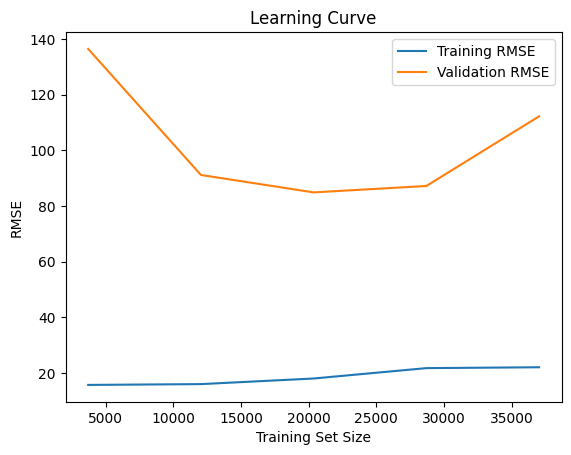

In [6]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# LGBMRegressor was used instead of Booster
model = LGBMRegressor(learning_rate=0.05, n_estimators=500, num_leaves=31, max_depth=-1)

# Use learning_curve for model evaluation
train_sizes, train_scores, valid_scores = learning_curve(
    model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error'
)

# Calculate and plot the learning curve
plt.plot(train_sizes, -train_scores.mean(axis=1), label='Training RMSE')
plt.plot(train_sizes, -valid_scores.mean(axis=1), label='Validation RMSE')
plt.legend()
plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('RMSE')
plt.show()